In [1]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression, PoissonRegressor


from vision.misc import notebook_analysis_help_funcs
import importlib
importlib.reload(notebook_analysis_help_funcs)
from vision.misc.notebook_analysis_help_funcs import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/fruitspec-lab/anaconda3/envs/FsCounterGPUtest/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
master_folder = "/media/fruitspec-lab/cam175/customers_new/MOTCHA"
# master_folder = "/media/fruitspec-lab/Extreme Pro/MOTCHA"
row_lengths = run_on_folder(master_folder, return_time=True)
row_lengths

{'MOTCHA_BEERAMU0_R107_S1(220823)': (70.65422776056182, 13),
 'MOTCHA_BEERAMU0_R108_S1(220823)': (77.59997937232808, 13),
 'MOTCHA_BEERAMU0_R113_S1(220823)': (70.60296211402168, 13),
 'MOTCHA_BEERAMU0_R114_S1(220823)': (72.67555623636635, 13),
 'MOTCHA_BEERAMU0_R2_S1(220823)': (73.4919346211541, 9),
 'MOTCHA_BEERAMU0_R23_S1(220823)': (70.5011800399214, 16),
 'MOTCHA_BEERAMU0_R24_S1(220823)': (71.19340778185054, 16),
 'MOTCHA_BEERAMU0_R29_S1(220823)': (71.4173917157935, 16),
 'MOTCHA_BEERAMU0_R3_S1(220823)': (69.43683695363933, 9),
 'MOTCHA_BEERAMU0_R30_S1(220823)': (73.58567336228793, 16),
 'MOTCHA_BEERAMU0_R8_S1(220823)': (70.84619494900096, 10),
 'MOTCHA_BEERAMU0_R9_S1(220823)': (71.05992568088709, 10),
 'MOTCHA_MEIRAVHA_R101_S1(230723)': (0, 14),
 'MOTCHA_MICHAL22_R101_S1(240723)': (0, 15),
 'MOTCHA_MICHAL22_R102_S2(240723)': (0, 15),
 'MOTCHA_OR2009_R11_S1(210823)': (161.17328539259395, 9),
 'MOTCHA_OR2009_R29_S1(210823)': (69.13429151431586, 12),
 'MOTCHA_OR2009_R32_S1(210823)': (

In [3]:
n_tracks = run_on_folder_tracks(master_folder, max_depth=5, full_cv=True)
n_tracks

{'MOTCHA_BEERAMU0_R107_S1(220823)': (11042,
  6165,
  4373,
  3353,
  2630,
  35633,
  0.0),
 'MOTCHA_BEERAMU0_R108_S1(220823)': (9183, 4925, 3458, 2554, 1994, 27401, 0.0),
 'MOTCHA_BEERAMU0_R113_S1(220823)': (9961, 5420, 3749, 2799, 2129, 29603, 0.0),
 'MOTCHA_BEERAMU0_R114_S1(220823)': (10393,
  5940,
  4317,
  3319,
  2637,
  34581,
  0.0),
 'MOTCHA_BEERAMU0_R2_S1(220823)': (9542, 4858, 2928, 1860, 1204, 22255, 0.0),
 'MOTCHA_BEERAMU0_R23_S1(220823)': (8326, 4305, 2837, 2057, 1538, 22542, 0.0),
 'MOTCHA_BEERAMU0_R24_S1(220823)': (10403,
  5288,
  3333,
  2179,
  1400,
  24928,
  16.0),
 'MOTCHA_BEERAMU0_R29_S1(220823)': (8870, 4399, 2878, 2088, 1582, 23588, 0.0),
 'MOTCHA_BEERAMU0_R3_S1(220823)': (9381, 4278, 2567, 1655, 1098, 20929, 0.0),
 'MOTCHA_BEERAMU0_R30_S1(220823)': (9562, 4915, 3034, 1992, 1344, 23661, 0.0),
 'MOTCHA_BEERAMU0_R8_S1(220823)': (10784, 5508, 3673, 2614, 1898, 28864, 0.0),
 'MOTCHA_BEERAMU0_R9_S1(220823)': (7930, 3973, 2729, 2037, 1620, 22638, 0.0),
 'MOTCHA_ME

In [4]:
df_out = pd.DataFrame(n_tracks).T
df_out.columns = ["cv1", "cv2", "cv3", "cv4", "cv5", "n_dets", "ndropped"] #"depth_1", "depth_2", "depth_3"]
df_out.reset_index(names = "block", inplace = True)
row_len_df = pd.DataFrame(row_lengths).T
row_len_df.columns = ["row_len" , "time"]
df_out = df_out.merge(row_len_df.rename_axis('block'), on = "block")
for i in range(1,6):
    df_out[f"cv{i}_per_meter"] = df_out[f"cv{i}"]/df_out["row_len"]
df_out[f"dets_per_meter"] = df_out["n_dets"]/df_out["row_len"]
df_out = df_out[df_out["row_len"] > 60].reset_index(drop = True)
# df_out["time"] = df_out["time"].map({9: 'morning',
#                                      10: 'morning',
#            12: 'noon',
#            13: 'noon',
#            15: "sundown",
#            16: "sundown"})
# df_out.sort_values("block")

In [5]:
df_out["counter_row"] = df_out["block"].apply(lambda x: x.split("_")[2][1:]).apply(int)
df_out["block_name"] = df_out["block"].apply(lambda x: x.split("_")[1])

In [6]:
# df_out.to_csv("/home/fruitspec-lab/Downloads/MEHADRIN.csv")

In [7]:
real_row_path = "/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_row_tags.csv"
df_real_row = pd.read_csv(real_row_path, encoding='ISO-8859-1')

In [8]:
df_out["row"] = df_out["block_name"] + "_R" + df_out["counter_row"].apply(str)

In [9]:
df_real_row["row"] = df_real_row["Block_name_row_tags"] +  "_R" + df_real_row["counter_row"].apply(str)

In [10]:
df_out = df_out.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")

In [11]:
df_out["sunside"] = df_out["sunside"].apply(lambda x: x.replace("back", "rear") if isinstance(x,str) else x)

In [12]:
# OR2009
# B sundown = towards sun
# B morning = sun is behind
# A morning = towards sun
# A sundown = sun is behind
grp_res = df_out.groupby(["real_row", "sunside", "block_name"]).median().drop(
    ["counter_row", "row_len", "ndropped"],axis = 1).reset_index()
grp_res["cv2/cv1"] = grp_res["cv2"]/grp_res["cv1"]
grp_res["cv3/cv1"] = grp_res["cv3"]/grp_res["cv1"]
grp_res

,real_row,sunside,block_name,cv1,cv2,cv3,cv4,cv5,n_dets,time,cv1_per_meter,cv2_per_meter,cv3_per_meter,cv4_per_meter,cv5_per_meter,dets_per_meter,cv2/cv1,cv3/cv1
0,1,front,OR2009,22614.5,11585.5,6966.0,4448.5,2900.5,53923.5,12.0,145.406598,74.458628,44.746905,28.562783,18.614048,346.486669,0.512304,0.308032
1,1,noon,OR2009,13347.0,8535.0,6525.5,5254.5,4313.5,52041.0,12.0,122.408244,77.760511,58.862168,46.948014,38.133255,464.467478,0.639470,0.488911
2,1,rear,OR2009,14776.0,9205.0,7069.0,5631.5,4602.5,55346.0,12.0,97.316111,60.554814,46.482806,37.014749,30.237167,363.820613,0.622970,0.478411
3,2,front,OR2009,21490.0,11231.5,6968.0,4602.5,3139.0,55536.0,12.0,135.168633,70.660707,43.853209,28.972715,19.765541,349.406828,0.522638,0.324244
4,2,noon,OR2009,15156.5,9300.0,7110.5,5648.5,4547.0,56278.0,12.5,99.000907,60.702076,46.377563,36.833555,29.639573,367.010155,0.613598,0.469139
5,2,rear,OR2009,11231.5,6860.5,5192.0,4122.0,3303.5,40068.0,12.0,70.072985,42.789328,32.379138,25.702819,20.595222,249.828115,0.610827,0.462271
6,3,noon_side_front,ORSCHIST,8401.0,4432.0,3204.0,2516.0,2039.0,27121.0,12.0,89.982290,47.470719,34.317731,26.948630,21.839530,290.490382,0.527556,0.381383
7,3,noon_side_rear,ORSCHIST,8586.0,4702.0,3512.0,2828.0,2349.0,29426.0,12.0,90.771807,49.709881,37.129115,29.897818,24.833796,311.093778,0.547636,0.409038
8,3,side_front,ORSCHIST,8904.5,4752.0,3472.5,2746.0,2242.0,29735.5,12.5,88.829480,47.366182,34.607193,27.360917,22.357800,297.107427,0.533663,0.389971
9,3,side_rear,ORSCHIST,8940.0,4780.0,3560.0,2915.0,2482.0,32462.5,12.5,89.596909,47.851269,35.608743,29.154026,24.820208,324.911163,0.534676,0.398210


In [13]:
grp_res["block_row"] = grp_res["block_name"] + "_R" + grp_res["real_row"].apply(str)

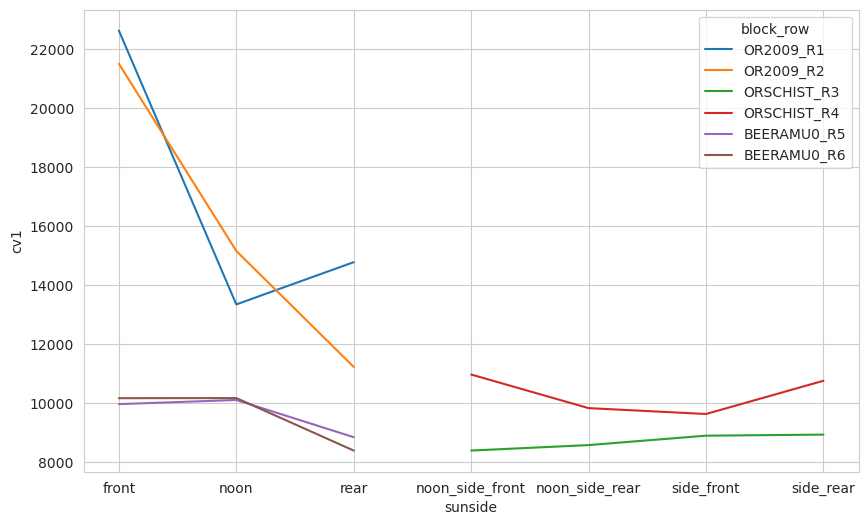

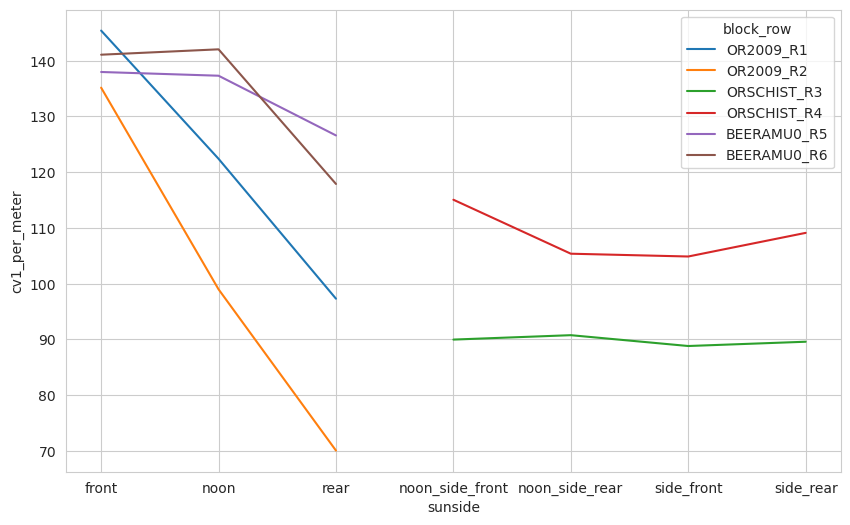

In [14]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1", hue = "block_row")
plt.show()
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1_per_meter", hue = "block_row")
plt.show()

# CV sunside analysis after slicing

In [15]:
or2009_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/OR2009/cv_features.csv"
BEERAMU0_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/BEERAMU0/cv_features.csv"
ORSHICHT_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/ORSCHIST/cv_features.csv"
cv_features_paths = [or2009_cv_features, BEERAMU0_cv_features, ORSHICHT_cv_features]
cv_df = pd.concat([pd.read_csv(p) for p in cv_features_paths])

In [16]:
cv_df["row"] = cv_df["block_name"] + "_" + cv_df["name"].apply(lambda x: x.split("_")[0])
value_counts = cv_df['row'].value_counts()
valid_row = list(value_counts[value_counts==1].index)
valid_trees = (cv_df["name"][cv_df["name"].str.contains("T11")]).values
cv_df_valid = cv_df[np.isin(cv_df["row"], valid_row) | np.isin(cv_df["name"], valid_trees)]

In [17]:
cv_df_valid = cv_df_valid.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")
cv_df_valid["sunside"] = cv_df_valid["sunside"].apply(lambda x: x.replace("back", "rear"))


In [18]:
cv_df_valid["block_real_row"] = cv_df_valid["block_name"] + "_R" + cv_df_valid["real_row"].apply(str)

In [19]:
cv_df_valid[["cv1", "real_row", "sunside", "block_name", "row"]].sort_values(["real_row", "sunside"])

,cv1,real_row,sunside,block_name,row
8,5277,1,front,OR2009,OR2009_R54
10,4138,1,front,OR2009,OR2009_R7
1,3179,1,noon,OR2009,OR2009_R29
2,3806,1,noon,OR2009,OR2009_R32
7,2586,1,rear,OR2009,OR2009_R53
9,3515,1,rear,OR2009,OR2009_R6
6,4667,2,front,OR2009,OR2009_R47
11,4485,2,front,OR2009,OR2009_R9
3,3145,2,noon,OR2009,OR2009_R33
4,3159,2,noon,OR2009,OR2009_R34


In [20]:
grp_res_cv = cv_df_valid.groupby(["real_row", "sunside", "block_name"]).median().reset_index()
grp_res_cv["block_real_row"] = grp_res_cv["block_name"] + "_R" + grp_res_cv["real_row"].apply(str)
grp_res_cv = grp_res_cv.sort_values(["block_name","sunside"])

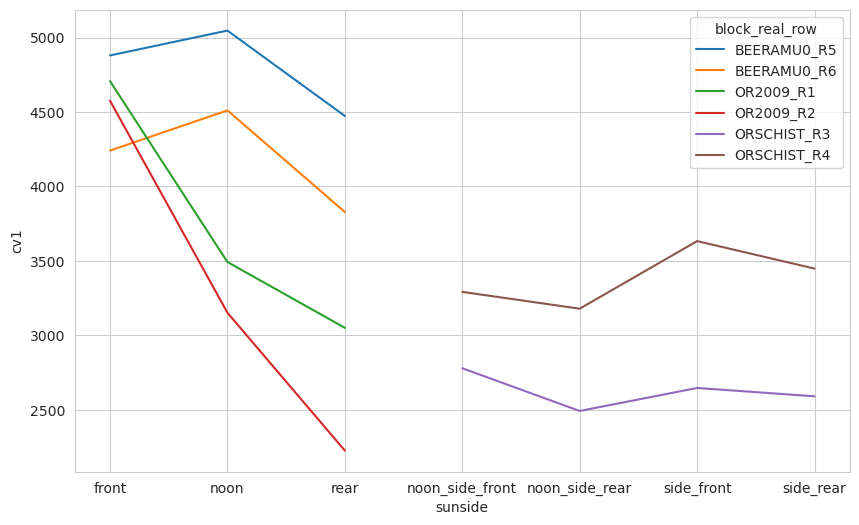

In [21]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res_cv, x = "sunside", y= "cv1", hue = "block_real_row")
plt.show()

In [22]:
dfs_list = []
for real_row in grp_res_cv["real_row"].unique():
    real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
    if not "side" in real_row_subdf["sunside"].iloc[0]:
        real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
        front_cv = real_row_subdf[real_row_subdf["sunside"] == "front"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]                                                                            
        noon_cv = real_row_subdf[real_row_subdf["sunside"] == "noon"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        rear_cv = real_row_subdf[real_row_subdf["sunside"] == "rear"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        ratios_df = pd.concat([front_cv/noon_cv, rear_cv/noon_cv])
        ratios_df["real_row"] = real_row
        ratios_df["sunside"] = ["front", "rear"]
        dfs_list.append(ratios_df)
factor_ratios = pd.concat(dfs_list)


In [23]:
1/factor_ratios[np.isin(factor_ratios["real_row"], [1,2])].groupby("sunside").mean()

,cv1,cv2,cv3,cv4,cv5,real_row
sunside,,,,,,
front,0.714371,0.844879,1.051221,1.297317,1.594068,0.666667
rear,1.266094,1.247948,1.237974,1.260584,1.276936,0.666667


In [24]:
factor_ratios.groupby("sunside").median()

,cv1,cv2,cv3,cv4,cv5,real_row
sunside,,,,,,
front,1.157400,0.985457,0.808822,0.721203,0.628604,3.5
rear,0.861073,0.773563,0.720983,0.701788,0.691846,3.5


# F_modeling

### Load data

In [25]:
features_df = cv_df.copy()
f_df = pd.read_csv("/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_F.csv")


In [26]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

In [27]:
features_df["real_row"] = features_df["row"].map(dict(zip(df_real_row["row"],
                                                              df_real_row["Block_name_row_tags"] +
                                                          "_R" + df_real_row["real_row"].apply(str))))
features_df["sunside"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["sunside"])))
features_df["side"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["side"])))

In [28]:
# merge F on name
df_f_org = features_df
df_f_org["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))

In [29]:
rows_F = df_f_org.groupby("real_row")["F"].sum()/2
cv_df_valid["F"] = cv_df_valid["block_real_row"].map(dict(rows_F))
cv_df_valid["factor"] = cv_df_valid["F"]/cv_df_valid["cv1"]

In [30]:
df_f_org = df_f_org[~df_f_org["F"].isna()].reset_index(drop = True)

In [31]:
df_f_org[[f"cv{i}" for i in range(1,6)] + 
         ["F", "name", "block_name"]].to_csv("/media/fruitspec-lab/cam175/MEHADRINEXP/MEHADRINEXP_cv_and_F.csv")


In [32]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_f_org[cv_F_col] = df_f_org[cv_col]/df_f_org["F"]

In [33]:
# df_f_org.to_csv(f"{df_f_path.split('.')[0]}_cvf.csv")

### Short EDA

In [34]:
df_f_org[df_f_org["side"] == "B"][cv_F_cols].mean().round(2)

cv1/F    0.56
cv2/F    0.32
cv3/F    0.23
cv4/F    0.18
cv5/F    0.15
dtype: float64

In [35]:
df_f_org.groupby(["block_name"])[cv_F_cols].mean().round(2)

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BEERAMU0,0.69,0.37,0.26,0.19,0.15
OR2009,0.40,0.25,0.19,0.15,0.12
ORSCHIST,0.57,0.31,0.23,0.18,0.15


In [36]:
df_f = df_f_org.copy()

### CV-F graphs

<Figure size 1000x600 with 0 Axes>

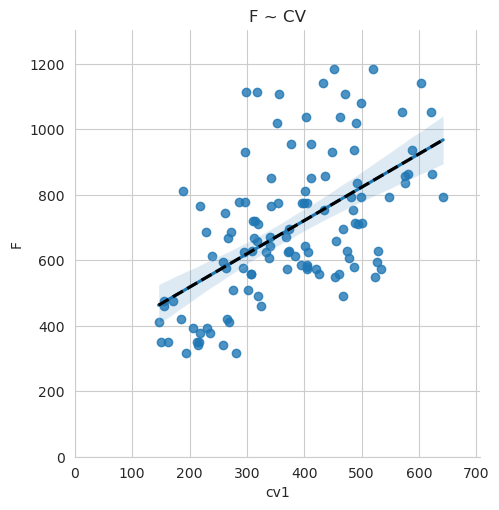

In [37]:
plot_F_cv(df_f_org, "1", title = "F ~ CV", add_xy_line=False)

<Figure size 1000x600 with 0 Axes>

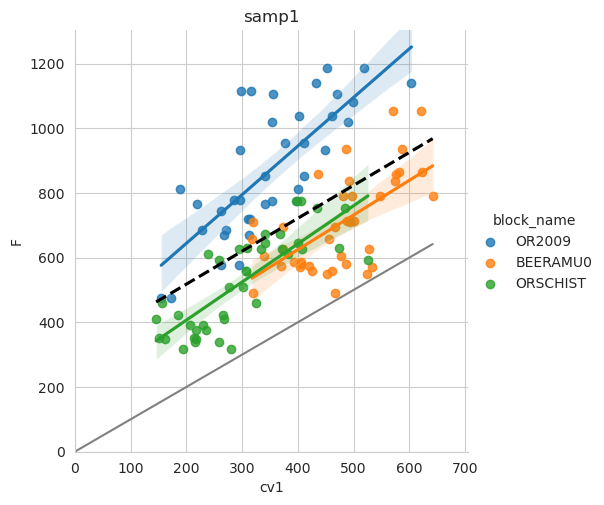

<Figure size 1000x600 with 0 Axes>

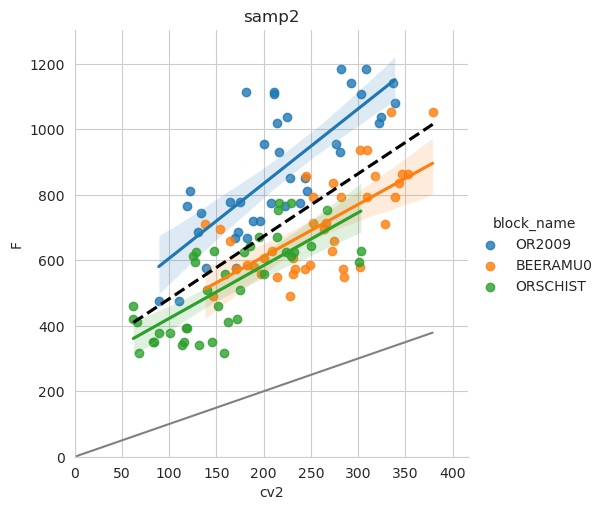

<Figure size 1000x600 with 0 Axes>

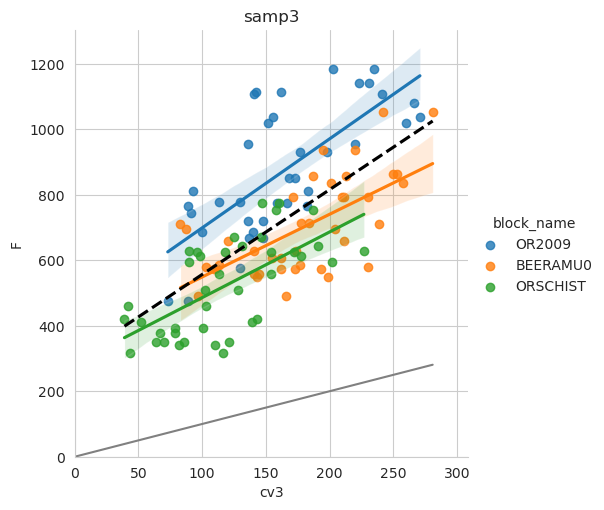

<Figure size 1000x600 with 0 Axes>

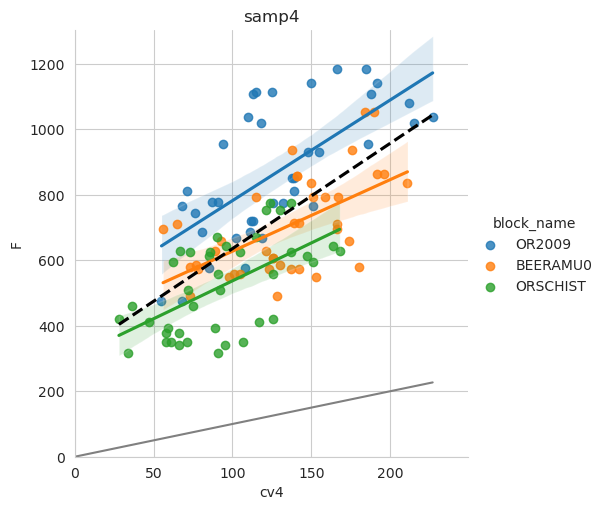

<Figure size 1000x600 with 0 Axes>

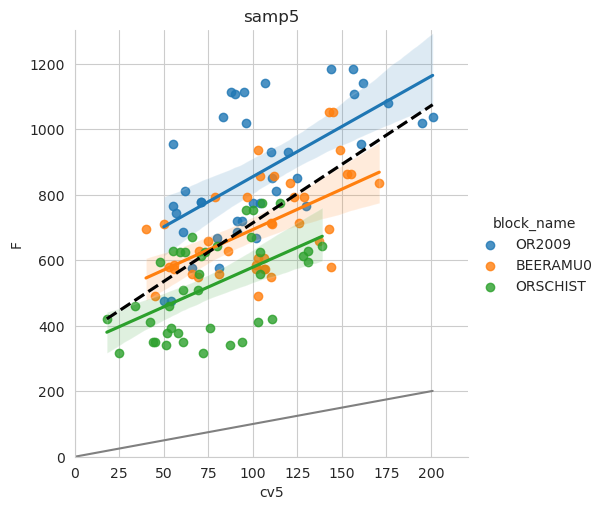

In [38]:
for i in range(1,6):
    plot_F_cv(df_f,i,"block_name", f"samp{i}")

<Figure size 1000x600 with 0 Axes>

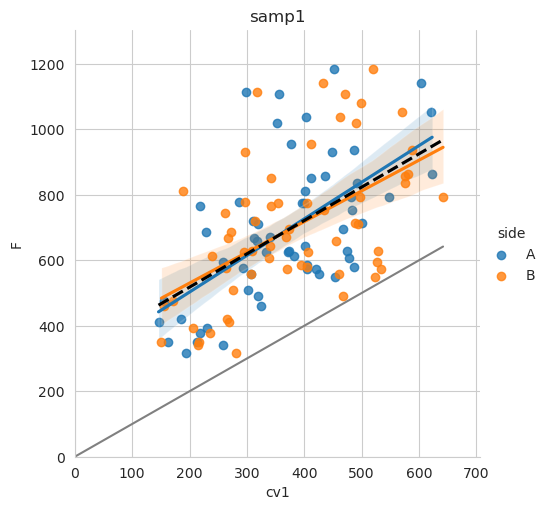

<Figure size 1000x600 with 0 Axes>

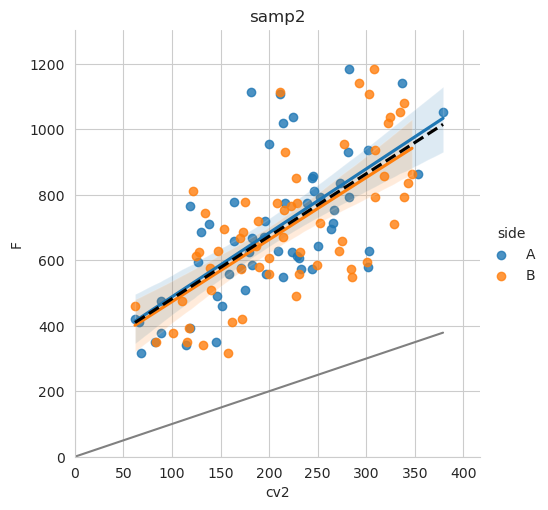

<Figure size 1000x600 with 0 Axes>

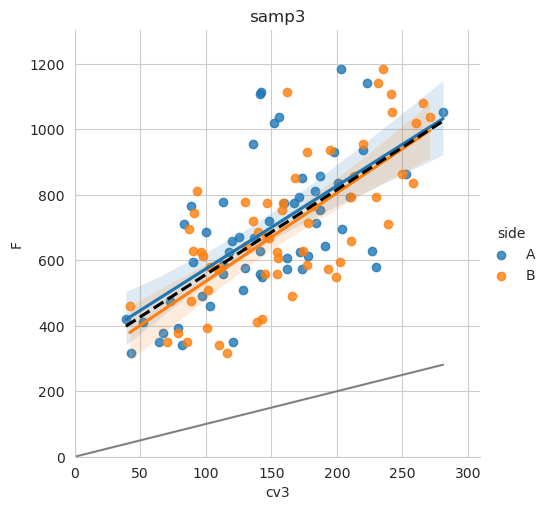

<Figure size 1000x600 with 0 Axes>

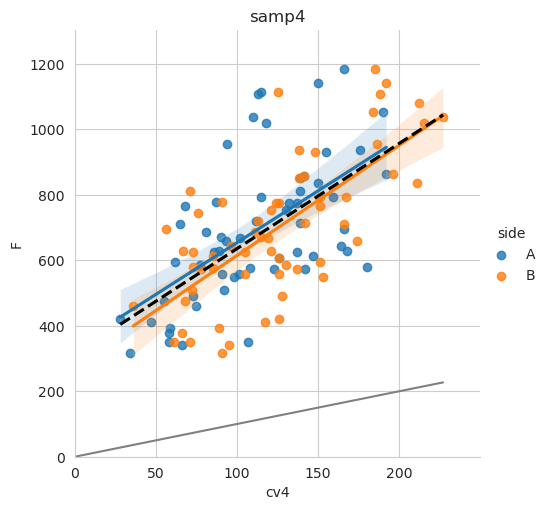

<Figure size 1000x600 with 0 Axes>

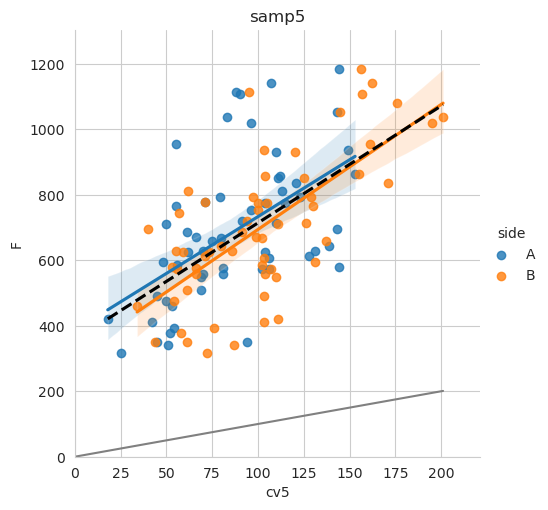

In [39]:
for i in range(1,6):
    plot_F_cv(df_f,i,"side", f"samp{i}")

### Modeling

In [40]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

In [53]:
df_f["row"] = df_f["real_row"]

df = df_f.reset_index(drop = True).copy()
X = df[["cv1"]]
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 12340.0,    pred: 12236.00637950412. (0.84 %) (ORSCHIST_R4)
true: 8508.0,    pred: 8916.927038615913. (4.81 %) (ORSCHIST_R3)
true: 16858.0,    pred: 10403.50341590565. (38.29 %) (OR2009_R2)
true: 13360.0,    pred: 16230.377369238542. (21.48 %) (BEERAMU0_R6)
true: 14748.0,    pred: 19335.627666703767. (31.11 %) (BEERAMU0_R5)
true: 14334.0,    pred: 10549.479548159708. (26.40 %) (OR2009_R1)
0.26224798358617873 0.0873122595643395
(0.20488433378842932, 0.13524064475507086)
true: 20848.0,    pred: 21293.903234991845. (2.14 %) (ORSCHIST)
true: 28108.0,    pred: 39598.84244930681. (40.88 %) (BEERAMU0)
true: 31192.0,    pred: 19281.36296448299. (38.18 %) (OR2009)
0.3265286227344315 0.11985019049286934
(0.27068259507808295, 0.1766209930522387)
0.0 [1.77160015]


In [42]:
run_LROCV_by_block(df_f, "cv1")

true: 16858.0,    pred: 14253.82255769432. (15.45 %) (OR2009_R2)
true: 16158.0,    pred: 18182.46195572442. (12.53 %) (OR2009_R1)
0.16825019350511006 0.021110853103159036
(0.1398844326221083, 0.0145928151122421)
[2.41114968]
true: 13360.0,    pred: 12716.236566254573. (4.82 %) (BEERAMU0_R6)
true: 14748.0,    pred: 15262.67496497816. (3.49 %) (BEERAMU0_R5)
0.1390847511015329 0.010744732363753506
(0.04154191782470904, 0.006643967934679237)
[1.47249732]
true: 12340.0,    pred: 11210.655880763215. (9.15 %) (ORSCHIST_R4)
true: 8508.0,    pred: 8700.759818147068. (2.27 %) (ORSCHIST_R3)
0.1635577369839215 0.017621196231003028
(0.05708763723570197, 0.034431335149774894)
[1.70030378]


In [43]:
run_LROCV_by_block(df_f, "cv1")

true: 16858.0,    pred: 14253.82255769432. (15.45 %) (OR2009_R2)
true: 16158.0,    pred: 18182.46195572442. (12.53 %) (OR2009_R1)
0.16825019350511006 0.021110853103159036
(0.1398844326221083, 0.0145928151122421)
[2.41114968]
true: 13360.0,    pred: 12716.236566254573. (4.82 %) (BEERAMU0_R6)
true: 14748.0,    pred: 15262.67496497816. (3.49 %) (BEERAMU0_R5)
0.1390847511015329 0.010744732363753506
(0.04154191782470904, 0.006643967934679237)
[1.47249732]
true: 12340.0,    pred: 11210.655880763215. (9.15 %) (ORSCHIST_R4)
true: 8508.0,    pred: 8700.759818147068. (2.27 %) (ORSCHIST_R3)
0.1635577369839215 0.017621196231003028
(0.05708763723570197, 0.034431335149774894)
[1.70030378]


In [44]:
run_LROCV_by_block(df_f, "cv1", fit_intercept=True)

true: 16858.0,    pred: 15645.884210083103. (7.19 %) (OR2009_R2)
true: 16158.0,    pred: 17473.973410320625. (8.14 %) (OR2009_R1)
0.13635264330861963 0.01761613956503493
(0.07667279792237311, 0.004771279953640302)
[1.50366081]
true: 13360.0,    pred: 13168.068724934787. (1.44 %) (BEERAMU0_R6)
true: 14748.0,    pred: 14629.440606357322. (0.80 %) (BEERAMU0_R5)
0.133954392704225 0.009424398075896782
(0.011202564215872415, 0.003163549187212421)
[1.07206553]
true: 12340.0,    pred: 10331.420870613516. (16.28 %) (ORSCHIST_R4)
true: 8508.0,    pred: 10759.022720125231. (26.46 %) (ORSCHIST_R3)
0.24679211484418173 0.07176231981057123
(0.21367348606195768, 0.050903702481205335)
[1.17890942]


# 2 sided test

In [45]:
# f_df_serinal["base_tree_name"] = base_tree_name
# f_df_serinal["tree_new_name"] = tree_new_name
# features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
# features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["tree_new_name"])))
# features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["side"])))

In [46]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]
f_df_serinal = f_df[~f_df["tree_serial"].isna()]
f_df_serinal["side"].replace({"A":1, "B":2}, inplace=True)

f_df_serinal["real_row"] = f_df_serinal["full_name"].map(dict(zip(features_df["full_name"],
                                      features_df["real_row"])))
f_df_serinal["real_row"].fillna("OR2009_R1", inplace = True)

base_tree_name = f_df_serinal["real_row"] + "_T" + f_df_serinal["tree_serial"].astype(int).astype(str)
tree_new_name = base_tree_name + "_S" + f_df_serinal["side"].replace({"A":1, "B":2}).astype(int).astype(str)
tree_new_name = tree_new_name.apply(lambda x: f'{x.split("_")[1]}_{x.split("_")[3]}_{x.split("_")[2]}')
f_df_serinal["base_tree_name"] = base_tree_name
f_df_serinal["tree_new_name"] = tree_new_name
features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["tree_new_name"])))
features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["side"])))

In [47]:
df_f = features_df[~features_df["F"].isna()].copy().reset_index(drop=True)
cv_cols = ["cv1", "cv2", "cv3", "cv4" ,"cv5"]

df_f["base_tree_name"] = df_f["block_name"] + "_"  + df_f["name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[-1])
counts = df_f["base_tree_name"].value_counts()>1
df_f = df_f[df_f["base_tree_name"].map(dict(zip(counts.index, counts.values)))]


In [48]:
grouped_trees = df_f.groupby("base_tree_name")[cv_cols + ["F"]].mean()
grouped_trees[cv_cols] = grouped_trees[cv_cols]*2
grouped_trees["base_tree_name"] = list(grouped_trees.index)
grouped_trees["block_name"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0])

In [49]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    grouped_trees[cv_F_col] = grouped_trees[cv_col]/grouped_trees["F"]
grouped_trees.groupby("block_name")[cv_F_cols].mean().round(2)

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BEERAMU0,1.37,0.74,0.52,0.39,0.30
OR2009,0.81,0.49,0.37,0.29,0.24
ORSCHIST,1.15,0.62,0.45,0.36,0.30


In [50]:
grouped_trees["real_row"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[1])

In [51]:
operational_rows = {"1_1": "R1", 
                   "1_2": "R2", 
                   "2_1": "R2", 
                   "2_2": "R1", 
                   "3_1": "R3", 
                   "3_2": "R4", 
                   "4_1": "R4", 
                   "4_2": "R3", 
                   "5_1": "R5", 
                   "5_2": "R6", 
                   "6_1": "R6", 
                   "6_2": "R5"}
df_f["operational_rows"] = df_f["real_row"].apply(lambda x: x.split("_")[1][1:]) + "_" + df_f["side"].apply(int).apply(str)
df_f["operational_rows"] = df_f["operational_rows"].map(operational_rows)


In [52]:
results_list = []
include_fruits = False
include_interaction=False
for cv in range(1,6):
    # 2 sided
    df = grouped_trees.reset_index(drop=True).copy()
    gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
    res = {"model": "2_sided", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)

    df = df_f.reset_index(drop=True)
    gr_res, ge_std, tree_res, tree_std, oper_preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "operational_rows")
    df["oper_preds"] = oper_preds
    grpd_res = df.groupby(["block_name","operational_rows"])["F", "oper_preds"].sum().reset_index()
    gr_res = np.mean((abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"]))
    ge_std = np.std(abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"])
    res = {"model": "opertional", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)
    # 1 side 2 trees
#             df = df_f.reset_index(drop=True).copy()
#             gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#             lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#             res = {"model": "1_sided", "cv": cv,
#                    "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std, "tree_mape": tree_res, "tree_std": tree_std,
#                   "include_fruits": include_fruits, "include_interaction": include_interaction}
#             results_list.append(res)

    #side A only
#     df = df_f[df_f["side"] == 1].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "A", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)

    #side B only
#     df = df_f[df_f["side"] == 2].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "B", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)
                        
summary_res = pd.DataFrame(results_list)   
summary_res.round(3)

true: 10424.0,    pred: 10791.25073988085. (3.52 %) (ORSCHIST)
true: 14054.0,    pred: 20236.815303727577. (43.99 %) (BEERAMU0)
true: 15596.0,    pred: 9793.94619842416. (37.20 %) (OR2009)
0.30867552205298693 0.1609719402976523
true: 6170.0,    pred: 6212.413640965949. (0.69 %) (ORSCHIST_R4)
true: 4254.0,    pred: 4525.13615658406. (6.37 %) (ORSCHIST_R3)
true: 8429.0,    pred: 5281.39107653874. (37.34 %) (OR2009_R2)
true: 6680.0,    pred: 8253.881200143534. (23.56 %) (BEERAMU0_R6)
true: 7374.0,    pred: 9857.429742053904. (33.68 %) (BEERAMU0_R5)
true: 7167.0,    pred: 5365.257199815678. (25.14 %) (OR2009_R1)
0.23653967903492568 0.11611758796674942
true: 20848.0,    pred: 21293.903234991845. (2.14 %) (ORSCHIST)
true: 28108.0,    pred: 39598.84244930681. (40.88 %) (BEERAMU0)
true: 31192.0,    pred: 19281.36296448299. (38.18 %) (OR2009)
0.3265286227344315 0.11985019049286934
true: 14054.0,    pred: 18305.21072335702. (30.25 %) (R6)
true: 14054.0,    pred: 17202.057463651185. (22.40 %) (R5

,model,cv,LBOCV,LBOCV_std,LROCV,LROCV_std,tree_mape,tree_std
0,2_sided,1,0.282,0.177,0.211,0.134,0.309,0.161
1,opertional,1,0.271,0.178,0.202,0.137,0.327,0.120
2,2_sided,2,0.215,0.151,0.159,0.123,0.250,0.113
3,opertional,2,0.214,0.138,0.164,0.108,0.296,0.052
4,2_sided,3,0.178,0.118,0.132,0.105,0.208,0.081
5,opertional,3,0.172,0.122,0.134,0.103,0.277,0.016
6,2_sided,4,0.158,0.076,0.121,0.079,0.187,0.039
7,opertional,4,0.136,0.119,0.115,0.103,0.269,0.004
8,2_sided,5,0.137,0.047,0.106,0.068,0.182,0.009
9,opertional,5,0.127,0.100,0.116,0.091,0.280,0.022
